<a href="https://colab.research.google.com/github/MauriceLaf/CAP4630/blob/master/HW4_Pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW 4 #3 Pt 2

**To aid with grading, I have made new comments that I have added about data/decisions for classifiers in bold**

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 19:32:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   127MB/s    in 0.5s    

2020-04-21 19:32:46 (127 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with MobileNetV2 convolution base and custom densely connected layers

**I chose MobileNetV2 because of a source I found that both used MobileNetV2 and provided a good explanation of the uses of convolutionial bases as well as fine-tuning pre-trained models. SOURCE: https://www.tensorflow.org/tutorials/images/transfer_learning**

### Load the convolutional base

In [0]:
from keras.applications import MobileNetV2

conv_base = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

**Second of the two choices I went through was  the GlobalAveragePooling2D classifier. The global average pooling results are fed directly to the sigmoid layer.** SOURCE: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751 

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 26s 260ms/step - loss: 0.7404 - acc: 0.5480 - val_loss: 0.6241 - val_acc: 0.5420
Epoch 2/30
100/100 [==============================] - 17s 174ms/step - loss: 0.7186 - acc: 0.5635 - val_loss: 0.7392 - val_acc: 0.5980
Epoch 3/30
100/100 [==============================] - 17s 172ms/step - loss: 0.6848 - acc: 0.5785 - val_loss: 0.5159 - val_acc: 0.6560
Epoch 4/30
100/100 [==============================] - 18s 176ms/step - loss: 0.6570 - acc: 0.6100 - val_loss: 0.7582 - val_acc: 0.6960
Epoch 5/30
100/100 [==============================] - 17s 175ms/step - loss: 0.6356 - acc: 0.6370 - val_loss: 0.6178 - val_acc: 0.7300
Epoch 6/30
100/100 [==============================] - 17s 174ms/step - loss: 0.6111 - acc: 0.6705 - val_loss: 0.7663 - val_acc: 0.7530
Epoch 7/30
100/100 [==============================] - 17s 171ms/step - loss: 0.5968 - acc: 0.6785 - val_lo

**These initial results are worse than the initial results of the dense connected layer. However, this isn't yet fine tuned.**

## Display curves of loss and accuracy during training

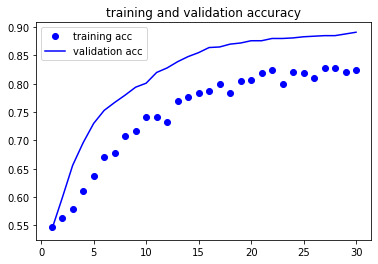

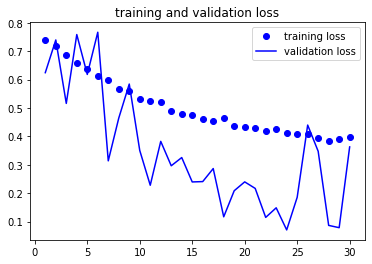

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**Using these classifiers, the overfitting is already less prevalent than with the dense connected layers.**

## Fine-tuning

**For MobileNetV2, fine tuning the upper layers allows us to retrain the non-generalize image reading layers and the more specific layers to recognize cats and dogs. The lower a layer is, the more general it is, and the higher a layer is, the more specific it is.**


**I selected the first 105 layers to fine tune**

**Source: https://www.tensorflow.org/tutorials/images/transfer_learning**

In [0]:
conv_base.trainable = True

print("Number of layers in the base model: ", len(conv_base.layers))

# Fine-tune from this layer onwards
fine_tune_at = 105

# Freeze all layers below the 50th to the bottom layer
for layer in conv_base.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 239ms/step - loss: 0.0417 - acc: 0.9845 - val_loss: 0.1510 - val_acc: 0.9580
Epoch 2/100
100/100 [==============================] - 18s 180ms/step - loss: 0.0383 - acc: 0.9860 - val_loss: 0.1549 - val_acc: 0.9560
Epoch 3/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0304 - acc: 0.9875 - val_loss: 0.1837 - val_acc: 0.9570
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0318 - acc: 0.9885 - val_loss: 0.0879 - val_acc: 0.9560
Epoch 5/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0363 - acc: 0.9875 - val_loss: 0.0074 - val_acc: 0.9580
Epoch 6/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0267 - acc: 0.9920 - val_loss: 0.3425 - val_acc: 0.9570
Epoch 7/100
100/100 [==============================] - 18s 181ms/step - loss: 0.0338 - acc: 0.9880 - val_loss: 0.1877 - val_acc: 0.9580
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

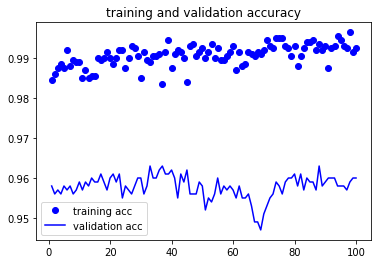

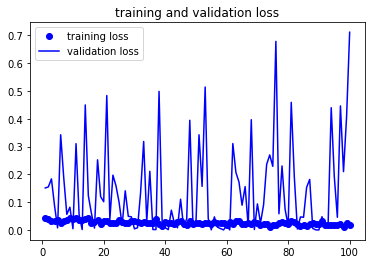

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

**The trained model is significantly more accurate and doesn't show that many jumps in the validation accuracy. The training accuracy is also very high. The increase in validation loss does signify overfitting, however.**

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.2544833068206435
Validation accuracy: 0.9499999916553498


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

##**Mini Conclusion:**

**While there is overfitting prevalent in both models, I believe that the jumps are significantly less intense in this model using MaxPooling.**